In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    #print(y_test.iloc[shot_index])
    #print(y_test.iloc[shot_index])
    id_value=y_test.iloc[shot_index].name
    #print(df_time_clean.loc[id_value])
    #print(y_test_reset.loc[shot_index])
    #print(df_input_clean.loc[id_value])
    return(df_input['shot number'].loc[id_value])

In [3]:
#Drop the shots <8000 from the raw max distribution
def clean_shots(df_input,df_time,df_freq_int):
    maxval_freq=df_freq_int.max(axis=1)
    meanval=maxval_freq.mean()
    twosigma=2*maxval_freq.std()
    print('')
    print('Shots with max val below 8000 will be discarded')
    print('')

    #get the indexes of the shots that don't fulfilll the requirement
    #badpoints_up=maxval_freq.index[(maxval_freq>(meanval+twosigma))].tolist()
    badpoints_down=maxval_freq.index[(maxval_freq<8000)].tolist()

    #Drop those shots from the databases
    df_input_clean=df_input.drop(badpoints_down)

    df_time_clean=df_time.drop(badpoints_down)

    df_freq_int_clean=df_freq_int.drop(badpoints_down)

    #reset their indexes
    df_input_clean.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    df_time_clean.reset_index(inplace=True,drop=True)
    df_freq_int_clean.reset_index(inplace=True,drop=True)

    #TESTING
    #print('Testing!')
    #print(df_freq_int_clean)
    #test the histogram
    #test_maxval_freq=df_freq_int_clean.max(axis=1)
    #test_maxval_freq.hist(bins=50)
    
    return df_input_clean,df_time_clean,df_freq_int_clean

# READ DATASET

In [4]:
df_input=pd.read_hdf('galadriel_dataset.h5','df_input')
df_time=pd.read_hdf('galadriel_dataset.h5','df_time')
df_freq_int=pd.read_hdf('galadriel_dataset.h5','df_freq_int')

#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Time values')
df_time_val=df_time.loc[0]
print(df_time_val)

print('----')
print("Intensity")
df_time= df_time.drop([0]) #drop the time values
df_time.reset_index(drop=True,inplace=True) #to start again from 0 (as the other DataFrames)
print(df_time)

print('----')
print("Freq values")
df_freq_val=df_freq_int.loc[0]
print(df_freq_val)

print('----')
print("Frequency intesity")
df_freq_int= df_freq_int.drop([0]) #drop the freq values
df_freq_int.reset_index(drop=True,inplace=True)
print(df_freq_int)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [5]:
#Get the clean shots
df_input_clean,df_time_clean,df_freq_int_clean=clean_shots(df_input,df_time,df_freq_int)


Shots with max val below 8000 will be discarded



In [6]:
df_input_clean.describe()

,shot number,order2,order3,order4
count,12150.000000,12150.000000,12150.000000,1.215000e+04
mean,10969.523374,35096.588477,5574.320988,-4.116642e+06
std,3589.767554,127.187774,13403.691056,2.907178e+05
min,4733.000000,34900.000000,-17000.000000,-4.600000e+06
25%,7865.250000,35000.000000,-6000.000000,-4.400000e+06
50%,10977.500000,35100.000000,5000.000000,-4.100000e+06
75%,14082.750000,35200.000000,17000.000000,-3.900000e+06
max,17151.000000,35300.000000,29000.000000,-3.600000e+06


In [7]:
#save the min and maximums for visualization purposes
min_order2=df_input_clean['order2'].min()
max_order2=df_input_clean['order2'].max()

min_order3=df_input_clean['order3'].min()
max_order3=df_input_clean['order3'].max()

min_order4=df_input_clean['order4'].min()
max_order4=df_input_clean['order4'].max()

### Define input/target in the model

In [8]:
#define input and output for the model

y=df_input_clean[['order2','order3','order4']]
X=df_time_clean

#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [9]:
#normalize the target (dazzler parameters has different order of magnitude)
y_train_reg = y_train.copy()
y_test_reg=y_test.copy()

y_train_reg['order2']= y_train_reg['order2']-y_train['order2'].mean()
y_train_reg['order2']= y_train_reg['order2']/y_train['order2'].std()

y_train_reg['order3']= y_train_reg['order3']-y_train['order3'].mean()
y_train_reg['order3']= y_train_reg['order3']/y_train['order3'].std()

y_train_reg['order4']= y_train_reg['order4']-y_train['order4'].mean()
y_train_reg['order4']= y_train_reg['order4']/y_train['order4'].std()

#Regularize the test dataset with the SAME values as the training set
y_test_reg['order2']= y_test_reg['order2']-y_train['order2'].mean()
y_test_reg['order2']= y_test_reg['order2']/y_train['order2'].std()

y_test_reg['order3']= y_test_reg['order3']-y_train['order3'].mean()
y_test_reg['order3']= y_test_reg['order3']/y_train['order3'].std()

y_test_reg['order4']= y_test_reg['order4']-y_train['order4'].mean()
y_test_reg['order4']= y_test_reg['order4']/y_train['order4'].std()

#print(y_train['order2'].mean())
#print(y_test_reg['order2'])
print(y_test_reg['order4'])

23       0.746839
4273     0.403606
1046     1.090071
9925     0.060373
4816    -0.626092
           ...   
6828     1.433304
4559    -0.282859
4014     1.090071
3894     0.403606
10701    0.060373
Name: order4, Length: 3645, dtype: float64


In [10]:
#convert to tensor (use regularized values)
X_train_tensor=torch.tensor(X_train.values,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_reg.values,dtype=torch.float32)

X_test_tensor=torch.tensor(X_test.values,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_reg.values,dtype=torch.float32)

### Construct random forest to compare results

In [11]:
forest_regr = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt',max_depth=20, random_state=18)
forest_regr.fit(X_train,y_train)

y_predict_forest=forest_regr.predict(X_test)

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

df_error_forest=abs(y_test_reset-y_predict_forest)

### Construct a fully connected NN to compare

In [12]:
#define the neural network
class perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(19,30)
        self.act1= nn.ReLU()
        self.hidden2=nn.Linear(30,30)
        self.act2=nn.ReLU()
        self.hidden3=nn.Linear(30,30)
        self.act3=nn.ReLU()
        self.hidden4=nn.Linear(30,25)
        self.act4=nn.ReLU()
        self.hidden5=nn.Linear(25,15)
        self.act5=nn.ReLU()
        self.hidden6=nn.Linear(15,10)
        self.act6=nn.ReLU()
        self.output=nn.Linear(10,3)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=self.act5(self.hidden5(x))
        x=self.act6(self.hidden6(x))
        x=self.output(x)
        return x

In [13]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


In [14]:
#hyperparameters
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

startTime = time.time()
#Create the model and define the loss and optimizer
nn_fc_model=perceptron().to(device)
#nn_model=cnn().to(device)
#print(nn_fc_model)

loss_func=nn.MSELoss() #mean squared error
optimizer = optim.Adam(nn_fc_model.parameters(), lr=learning_rate)

#main training loop
train_error=[]
test_error=[]
epoch_list=[]
for epoch in range(n_epochs):
    # set the model in training mode
    nn_fc_model.train()

    train_loss=0
    for i in range(0,len(X_train_tensor),batch_size):
        X_batch=X_train_tensor[i:i+batch_size]
        y_batch=y_train_tensor[i:i+batch_size]
        X_batch, y_batch =(X_batch.to(device), y_batch.to(device))
        y_predict_nn=nn_fc_model(X_batch)
        loss=loss_func(y_predict_nn,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    #get training error
    train_loss=train_loss/(len(X_train_tensor)/batch_size)
    train_error.append(train_loss.detach().cpu().numpy())
    #evaluate test error
    with torch.no_grad():
        nn_fc_model.eval()
        (X_test_tensor, y_test_tensor) = (X_test_tensor.to(device), y_test_tensor.to(device))
        y_predict_test=nn_fc_model(X_test_tensor)
        test_loss=loss_func(y_predict_test,y_test_tensor)
        test_error.append(test_loss.detach().cpu().numpy())

    epoch_list.append(epoch+1)
    
    if(epoch%print_freq==0 or epoch+1==n_epochs):
        print(f'Finished epoch {epoch},latest loss {train_loss}')
#print(train_error)
#print(test_error)
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Finished epoch 0,latest loss 0.7955352663993835
Finished epoch 10,latest loss 0.43874821066856384
Finished epoch 20,latest loss 0.35815271735191345
Finished epoch 30,latest loss 0.3002925515174866
Finished epoch 40,latest loss 0.27244800329208374
Finished epoch 50,latest loss 0.2576358914375305
Finished epoch 60,latest loss 0.24797090888023376
Finished epoch 70,latest loss 0.23864221572875977
Finished epoch 80,latest loss 0.2314239740371704
Finished epoch 90,latest loss 0.22444061934947968
Finished epoch 100,latest loss 0.2193523794412613
Finished epoch 110,latest loss 0.2130003571510315
Finished epoch 120,latest loss 0.20722118020057678
Finished epoch 130,latest loss 0.2030540406703949
Finished epoch 140,latest loss 0.1988295018672943
Finished epoch 150,latest loss 0.19439351558685303
Finished epoch 160,latest loss 0.19103145599365234
Finished epoch 170,latest loss 0.18829785287380219
Finished epoch 180,latest loss 0.185507133603096
Finished epoch 190,latest loss 0.18543025851249695
F

In [15]:
#Make the prediction (output is normalized)
y_predict_fc_nn_tensor=nn_fc_model(X_test_tensor)
y_predict_fc_nn_reg=y_predict_fc_nn_tensor.detach().cpu().numpy()

#Revert the target regularization
y_predict_fc_nn=y_predict_fc_nn_reg.copy()
y_predict_fc_nn[:,0]=(y_predict_fc_nn_reg[:,0]*y_train['order2'].std())+y_train['order2'].mean()
y_predict_fc_nn[:,1]=(y_predict_fc_nn_reg[:,1]*y_train['order3'].std())+y_train['order3'].mean()
y_predict_fc_nn[:,2]=(y_predict_fc_nn_reg[:,2]*y_train['order4'].std())+y_train['order4'].mean()

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

#Estimate the error
df_error_fc_nn=abs(y_test_reset-y_predict_fc_nn)

## CREATE THE CONVOLUTIONAL NN

### Define the network

In [16]:
#define the neural network
class cnn_small(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.act1= nn.ReLU()

        self.pool1 = nn.MaxPool1d(kernel_size=2,stride=1)

        self.conv2 = nn.Conv1d(in_channels=6, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.act2= nn.ReLU()
        
        self.pool2 = nn.MaxPool1d(kernel_size=3,stride=2)

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(80, 60)
        self.act3= nn.ReLU()

        self.fc4 = nn.Linear(60, 30)
        self.act4= nn.ReLU()

        self.fc5 = nn.Linear(30, 9)
        self.act5= nn.ReLU()

        self.output=nn.Linear(9,3)

    def forward(self,x):
        #input batchx1x19   output batchx6x19
        x=self.act1(self.conv1(x))
        #input batchx6x19   output batchx6x17
        x=self.pool1(x)
        
        #input batchx6x17   output batchx10x17
        x=self.act2(self.conv2(x))
        #input batchx10x17   output batchx10x8
        x=self.pool2(x)  
        
        #input batchx10x8 output batchx80
        x=self.flat(x)
        
        #input batchx80   output batchx60
        x=self.act3(self.fc3(x))
        #input batchx60   output batchx30
        x=self.act4(self.fc4(x))
        #input batchx30   output batchx9
        x=self.act5(self.fc5(x))
        #input batchx9   output batchx3
        x=self.output(x)
        return x

In [17]:
#define the neural network
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.act1= nn.ReLU()

        self.pool1 = nn.MaxPool1d(kernel_size=2,stride=1)

        self.conv2 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.act2= nn.ReLU()
        
        self.pool2 = nn.MaxPool1d(kernel_size=3,stride=2)

        self.conv3 = nn.Conv1d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.act3= nn.ReLU()
        
        self.pool3 = nn.MaxPool1d(kernel_size=2,stride=2)

        self.flat = nn.Flatten()

        self.fc4 = nn.Linear(80, 60)
        self.act4= nn.ReLU()

        self.fc5 = nn.Linear(60, 50)
        self.act5= nn.ReLU()

        self.fc6 = nn.Linear(50, 25)
        self.act6= nn.ReLU()

        self.output=nn.Linear(25,3)

    def forward(self,x):
        #input batchx1x19   output batchx6x19
        x=self.act1(self.conv1(x))
        #input batchx6x19   output batchx6x17
        x=self.pool1(x)
        
        #input batchx6x17   output batchx12x17
        x=self.act2(self.conv2(x))
        #input batchx12x17   output batchx12x8
        x=self.pool2(x) 

        #input batchx12x8   output batchx20x8
        x=self.act3(self.conv3(x))
        #input batchx20x8   output batchx20x4
        x=self.pool3(x) 
        
        #input batchx20x4 output batchx80
        x=self.flat(x)
        
        #input batchx80   output batchx60
        x=self.act4(self.fc4(x))
        #input batchx60   output batchx50
        x=self.act5(self.fc5(x))
        #input batchx50   output batchx25
        x=self.act6(self.fc6(x))
        #input batchx25   output batchx3
        x=self.output(x)
        return x

## Training phase

In [18]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


In [19]:
#hyperparameters
n_epochs=100
batch_size=20
print_freq=10
learning_rate=0.001

#MAIN LOOP
startTime = time.time()
#Create the model and define the loss and optimizer
#nn_model=perceptron().to(device)
nn_model=cnn().to(device)
#print(nn_model)

loss_func=nn.MSELoss() #mean squared error
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

#main training loop
train_error=[]
test_error=[]
epoch_list=[]
for epoch in range(n_epochs):
    # set the model in training mode
    nn_model.train()

    train_loss=0
    for i in range(0,len(X_train_tensor),batch_size):
        X_batch=X_train_tensor[i:i+batch_size]
        y_batch=y_train_tensor[i:i+batch_size]
        X_batch=X_batch.unsqueeze(1)
        ##y_batch=y_batch.unsqueeze(1)
        X_batch, y_batch =(X_batch.to(device), y_batch.to(device))
        y_predict_nn=nn_model(X_batch)
        loss=loss_func(y_predict_nn,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    #get training error
    train_loss=train_loss/(len(X_train_tensor)/batch_size)
    train_error.append(train_loss.detach().cpu().numpy())
    #evaluate test error
    with torch.no_grad():
        nn_model.eval()
        X_test_model=X_test_tensor.unsqueeze(1)
        y_test_model=y_test_tensor#.unsqueeze(1)
        (X_test_model, y_test_model) = (X_test_model.to(device), y_test_model.to(device))
        y_predict_test=nn_model(X_test_model)
        test_loss=loss_func(y_predict_test,y_test_model)
        test_error.append(test_loss.detach().cpu().numpy())

    epoch_list.append(epoch+1)
    
    if(epoch%print_freq==0 or epoch+1==n_epochs):
        print(f'Finished epoch {epoch},latest loss {train_loss}')
#print(train_error)
#print(test_error)
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Finished epoch 0,latest loss 0.8465750813484192
Finished epoch 10,latest loss 0.4789237380027771
Finished epoch 20,latest loss 0.3789263069629669
Finished epoch 30,latest loss 0.32043740153312683
Finished epoch 40,latest loss 0.28789594769477844
Finished epoch 50,latest loss 0.2660587430000305
Finished epoch 60,latest loss 0.2510644197463989
Finished epoch 70,latest loss 0.24151255190372467
Finished epoch 80,latest loss 0.23184499144554138
Finished epoch 90,latest loss 0.22666795551776886
Finished epoch 99,latest loss 0.2217349261045456
Total time taken to train the model: 56.74s


## Model performace

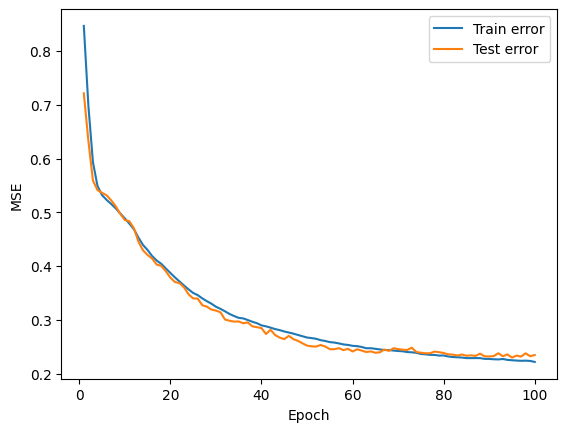

In [20]:
plt.plot(epoch_list,train_error,label='Train error')
plt.plot(epoch_list,test_error,label='Test error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

### Predictions

In [21]:
#Make the prediction (output is normalized)
y_predict_nn_tensor=nn_model(X_test_model)
y_predict_nn_reg=y_predict_nn_tensor.detach().cpu().numpy()

#Revert the target regularization
y_predict_nn=y_predict_nn_reg.copy()
y_predict_nn[:,0]=(y_predict_nn_reg[:,0]*y_train['order2'].std())+y_train['order2'].mean()
y_predict_nn[:,1]=(y_predict_nn_reg[:,1]*y_train['order3'].std())+y_train['order3'].mean()
y_predict_nn[:,2]=(y_predict_nn_reg[:,2]*y_train['order4'].std())+y_train['order4'].mean()

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

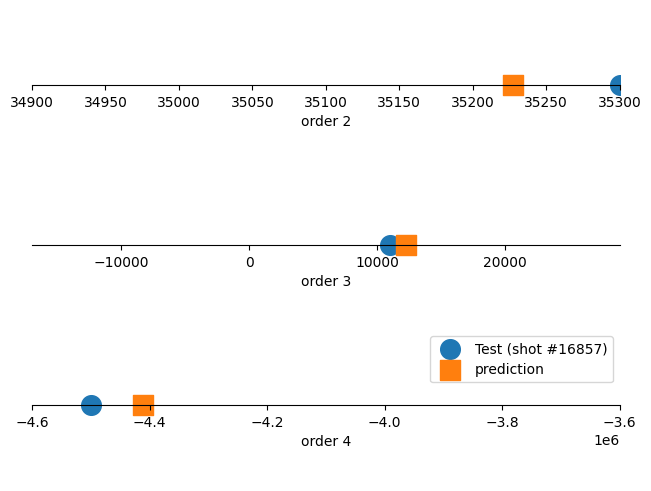

In [22]:
#plot a random prediction

shot_index=220 #this is not the shot number, nor the original index. It is the index from the model output
shot_numb=get_shot_num(shot_index,y_test,df_input_clean)
y_temp=[0]
fig, ax = plt.subplots(3, 1, layout='constrained')
#ax = plt.subplots(3,1) #upper plot
ax[0].scatter(y_test_reset['order2'].loc[shot_index],y_temp,200,label='Test')
ax[0].scatter(y_predict_nn[shot_index][0],y_temp,200,label='prediction',marker='s')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].spines['bottom'].set_position('zero')
ax[0].set_xlabel('order 2')
ax[0].set_xlim(min_order2,max_order2)
#plt.xlim(min_order2,max_order2)
#plt.show()

#ax2 = plt.subplot(3,2) #mid plot
ax[1].scatter(y_test_reset['order3'].loc[shot_index],y_temp,200,label='Test')
ax[1].scatter(y_predict_nn[shot_index][1],y_temp,200,label='prediction',marker='s')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].spines['bottom'].set_position('zero')
ax[1].set_xlabel('order 3')
ax[1].set_xlim(min_order3,max_order3)
#plt.xlim(min_order3,max_order3)
#plt.show()


#ax3 = plt.subplot(3,3) #lower plot
ax[2].scatter(y_test_reset['order4'].loc[shot_index],y_temp,200,label='Test (shot #'+str(shot_numb)+')')
ax[2].scatter(y_predict_nn[shot_index][2],y_temp,200,label='prediction',marker='s')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].yaxis.set_visible(False)
ax[2].spines['bottom'].set_position('zero')
ax[2].set_xlabel('order 4')
plt.xlim(min_order4,max_order4)
plt.legend()
plt.show()

In [23]:
df_error_nn=abs(y_test_reset-y_predict_nn)

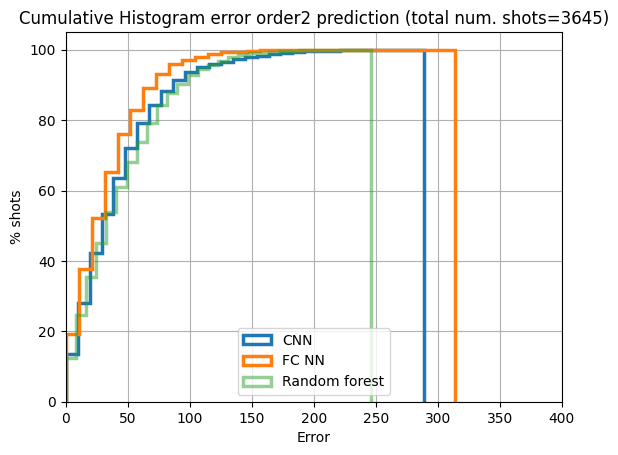

The average error for order2 is 11.13%
 
 


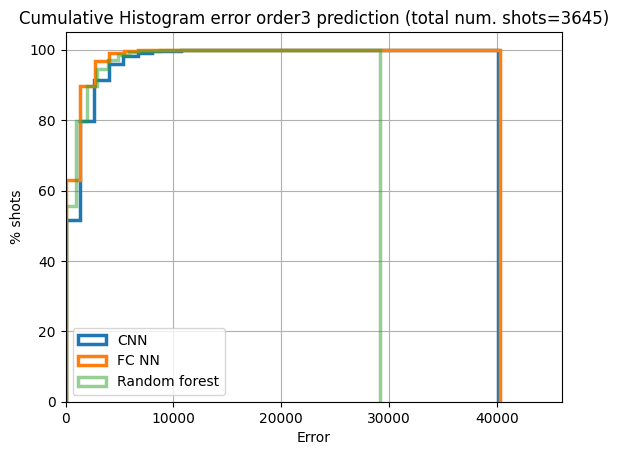

The average error for order3 is 3.79%
 
 


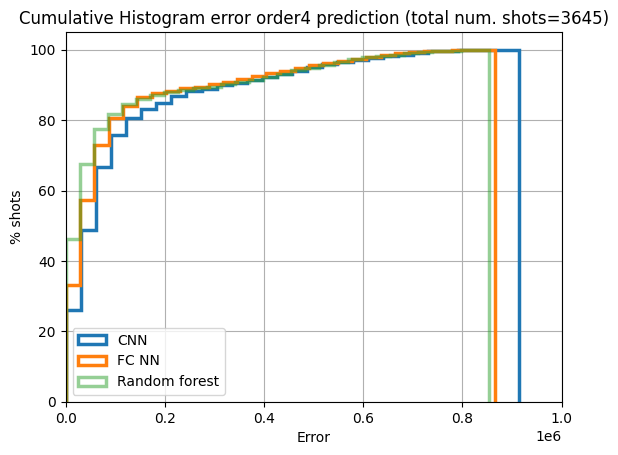

The average error for order4 is 11.86%
 
 


In [24]:
weights_forest_order2 = 100*np.ones_like(df_error_forest['order2']) / len(df_error_forest['order2'])
weights_nn_order2 = 100*np.ones_like(df_error_nn['order2']) / len(df_error_nn['order2'])
df_error_nn['order2'].hist(bins=30,label='CNN',cumulative=True,weights=weights_nn_order2,histtype="step",linewidth=2.5)
df_error_fc_nn['order2'].hist(bins=30,label='FC NN',cumulative=True,weights=weights_nn_order2,histtype="step",linewidth=2.5)
df_error_forest['order2'].hist(bins=30,alpha=0.5,label='Random forest',cumulative=True,weights=weights_forest_order2,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order2 prediction (total num. shots='+str(len(df_error_forest))+')')
plt.xlim(0,max_order2-min_order2)
plt.legend()
plt.show()

avg_error=100*df_error_nn['order2'].mean()/(max_order2-min_order2)
print('The average error for order2 is {:4.2f}%'.format(avg_error))
print(' ')
print(' ')

weights_forest_order3 = 100*np.ones_like(df_error_forest['order3']) / len(df_error_forest['order3'])
weights_nn_order3 = 100*np.ones_like(df_error_nn['order3']) / len(df_error_nn['order3'])
df_error_nn['order3'].hist(bins=30,label='CNN',cumulative=True,weights=weights_nn_order3,histtype="step",linewidth=2.5)
df_error_fc_nn['order3'].hist(bins=30,label='FC NN',cumulative=True,weights=weights_nn_order3,histtype="step",linewidth=2.5)
df_error_forest['order3'].hist(bins=30,alpha=0.5,label='Random forest',cumulative=True,weights=weights_forest_order3,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order3 prediction (total num. shots='+str(len(df_error_nn))+')')
plt.xlim(0,max_order3-min_order3)
plt.legend()
plt.show()

avg_error=100*df_error_nn['order3'].mean()/(max_order3-min_order3)
print('The average error for order3 is {:4.2f}%'.format(avg_error))
print(' ')
print(' ')

weights_forest_order4 = 100*np.ones_like(df_error_forest['order4']) / len(df_error_forest['order4'])
weights_nn_order4 = 100*np.ones_like(df_error_nn['order4']) / len(df_error_nn['order4'])
df_error_nn['order4'].hist(bins=30,label='CNN',cumulative=True,weights=weights_nn_order4,histtype="step",linewidth=2.5)
df_error_fc_nn['order4'].hist(bins=30,label='FC NN',cumulative=True,weights=weights_nn_order4,histtype="step",linewidth=2.5)
df_error_forest['order4'].hist(bins=30,alpha=0.5,label='Random forest',cumulative=True,weights=weights_forest_order4,histtype="step",linewidth=2.5)
plt.xlabel('Error')
plt.ylabel('% shots')
plt.title('Cumulative Histogram error order4 prediction (total num. shots='+str(len(df_error_nn))+')')
plt.xlim(0,max_order4-min_order4)
plt.legend()
plt.show()

avg_error=100*df_error_nn['order4'].mean()/(max_order4-min_order4)
print('The average error for order4 is {:4.2f}%'.format(avg_error))
print(' ')
print(' ')

In [25]:
pytorch_total_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)

In [26]:
pytorch_total_params

10255